In [11]:
import os
# 由已知0.2生成联合分布，我们只处理对pit的猜测，因此这个表有16列
# 16列，按0-1取值，那么联合分布表里就有2^16=65536条数据

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# +-1兼容版
import warnings
warnings.filterwarnings("ignore")

class Thing:
    def __init__(self, name=''):
        self.name = name
    def __repr__(self):
        return self.name

class WumpusGuess(Thing):
    def __init__(self, name='WumpusGuess'):
        super().__init__(name)
        self.table = self.gen_table()
    def gen_table(self, p=0.2, n=4):
        columns = []
        for x in range(n):
            for y in range(n):
                columns.append((x, y))
        columns = columns + ['p']
        data = []
        self.recurse_state([], 1, n * n, data)
        return pd.DataFrame(data=data, columns=columns)
    def recurse_state(self, state, p, n, data_arr):
        if len(state) == n:
            data_arr.append(state + [p])
        else:  # 因为分布在各个点之间是均匀的，所以可以直接乘0.2和0.8
            self.recurse_state(state + [1], p * 0.2, n, data_arr)
            self.recurse_state(state + [-1], p * 0.8, n, data_arr)
    def cal_p_cond(self, xs=[], conditions=[]):
        result = self.table
        for k, v in conditions:
            result = result[result[k] == v]
        result = result[['p'] + xs]
        if len(result) > 0:
            if len(xs) > 0:
                result = result.groupby(xs).sum()
                result = result / result.sum()
                print("P({}|{})={}".format(xs, conditions, result.to_json()))
            else:
                result = result.sum()
                print("P({}|{})={}".format(xs, conditions, result.to_json()))
        return result
    # 这些是事实
    def watch(self, xs):
        if len(xs) > 0:
            for k, v in xs:
                self.table = self.table[self.table[k] == v]
            self.table['p'] = self.table['p'] / self.table['p'].sum()
    # 这些是不可能的
    def impossible(self, xs):
        if len(xs) > 0:
            to_drop = self.table
            for k, v in xs:
                to_drop = to_drop[to_drop[k] == v]
            # print(len(to_drop))
            self.table.drop(index=to_drop.index, inplace=True)
            self.table['p'] = self.table['p'] / self.table['p'].sum()
    # 事实一定在下面当中的某一个
    def mustbe(self, xss):
        if len(xss) > 0:
            keep_final = []
            for xs in xss:
                to_keep = self.table
                for k, v in xs:
                    to_keep = to_keep[to_keep[k] == v]
                keep_final.append(to_keep)
            self.table = pd.concat(keep_final, axis=0)
            self.table['p'] = self.table['p'] / self.table['p'].sum()

pit_guess = WumpusGuess()
pit_guess.cal_p_cond([(1, 0)], [((0, 0), -1)])
pit_guess.cal_p_cond(conditions=[((0, 0), -1), ((1, 0), -1), ((0, 1), -1)])
pit_guess.cal_p_cond([(2, 0)])
pit_guess.cal_p_cond([(1, 1)])
pit_guess.cal_p_cond([(0, 2)])
# 一开始的时候，这些都是独立的，但是随着我们的观察，有一些情况可以排除掉

pit_guess = WumpusGuess()
pit_guess.watch([((0, 0), -1)])
pit_guess.watch([((0, 1), -1)])
pit_guess.watch([((1, 0), -1)])
pit_guess.cal_p_cond([(2, 0)])
pit_guess.cal_p_cond([(1, 1)])
pit_guess.cal_p_cond([(0, 2)])
# 使用不可能进行排除
print("使用不可能进行排除")
pit_guess = WumpusGuess()
pit_guess.impossible([((2, 0), -1), ((1, 1), -1), ((0, 2), -1)])
pit_guess.impossible([((2, 0), 1), ((1, 1), -1), ((0, 2), -1)])
pit_guess.impossible([((2, 0), -1), ((1, 1), -1), ((0, 2), 1)])
pit_guess.cal_p_cond([(2, 0)])
pit_guess.cal_p_cond([(1, 1)])
pit_guess.cal_p_cond([(0, 2)])
# 使用下列之一进行排除
print("使用下列之一进行排除")
pit_guess = WumpusGuess()
pit_guess.mustbe([[((2, 0), 1), ((1, 1), 1), ((0, 2), 1)],
                  [((2, 0), 1), ((1, 1), 1), ((0, 2), -1)],
                  [((2, 0), 1), ((1, 1), -1), ((0, 2), 1)],
                  [((2, 0), -1), ((1, 1), 1), ((0, 2), 1)],
                  [((2, 0), -1), ((1, 1), 1), ((0, 2), -1)]])
pit_guess.cal_p_cond([(2, 0)])
pit_guess.cal_p_cond([(1, 1)])
pit_guess.cal_p_cond([(0, 2)])
print("")


P([(1, 0)]|[((0, 0), -1)])={"p":{"-1":0.8,"1":0.2}}
P([]|[((0, 0), -1), ((1, 0), -1), ((0, 1), -1)])={"p":0.512}
P([(2, 0)]|[])={"p":{"-1":0.8,"1":0.2}}
P([(1, 1)]|[])={"p":{"-1":0.8,"1":0.2}}
P([(0, 2)]|[])={"p":{"-1":0.8,"1":0.2}}
P([(2, 0)]|[])={"p":{"-1":0.8,"1":0.2}}
P([(1, 1)]|[])={"p":{"-1":0.8,"1":0.2}}
P([(0, 2)]|[])={"p":{"-1":0.8,"1":0.2}}
使用不可能进行排除
P([(2, 0)]|[])={"p":{"-1":0.6896551724,"1":0.3103448276}}
P([(1, 1)]|[])={"p":{"-1":0.1379310345,"1":0.8620689655}}
P([(0, 2)]|[])={"p":{"-1":0.6896551724,"1":0.3103448276}}
使用下列之一进行排除
P([(2, 0)]|[])={"p":{"-1":0.6896551724,"1":0.3103448276}}
P([(1, 1)]|[])={"p":{"-1":0.1379310345,"1":0.8620689655}}
P([(0, 2)]|[])={"p":{"-1":0.6896551724,"1":0.3103448276}}



==========第1步==========
agent移动至(0, 0),分数-1,此地有


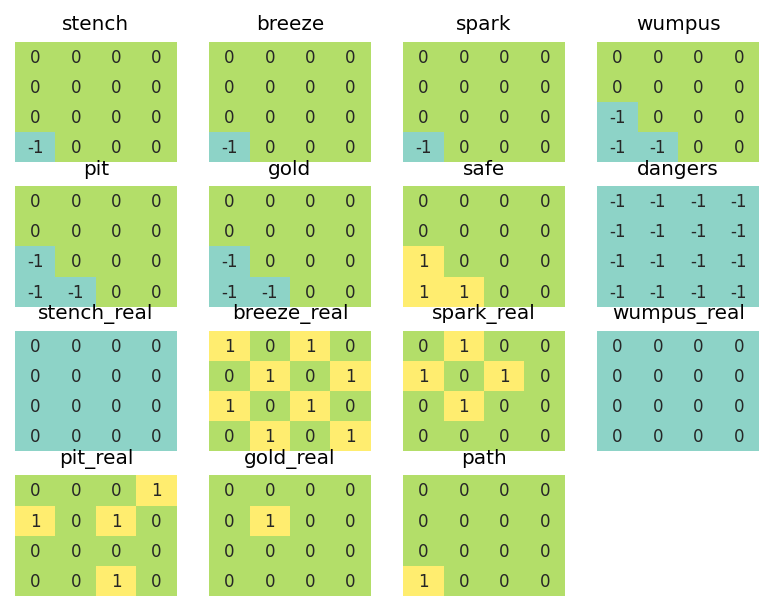

==========第2步==========
      loc  safe  wumpus  pit
0  (0, 1)   1.0       0    0
1  (1, 0)   1.0       0    0
这种情况不可能 [((0, 2), -1), ((1, 1), -1)]
这种情况不可能 [((0, 2), -1), ((1, 1), -1)]
agent移动至(0, 1),分数-2,此地有breeze


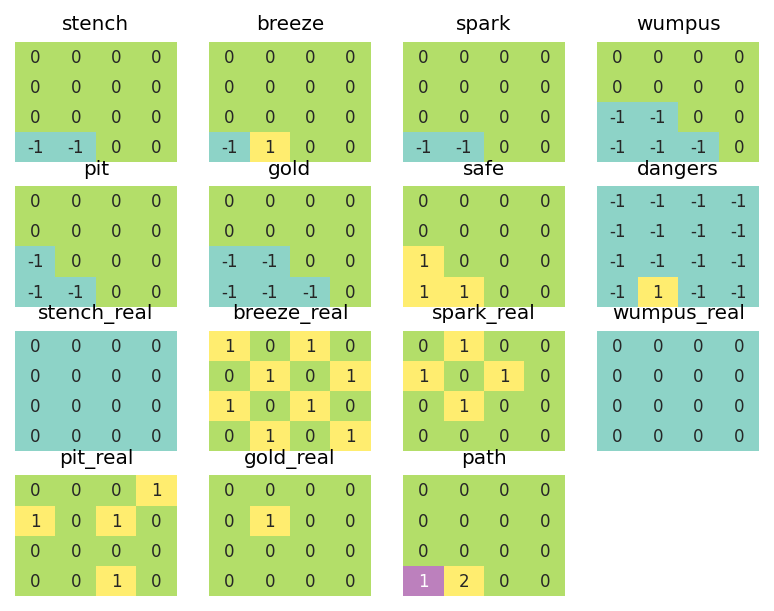

==========第3步==========
P([(0, 2)]|[])={"p":{"-1":0.4444444444,"1":0.5555555556}}
P([(1, 1)]|[])={"p":{"-1":0.4444444444,"1":0.5555555556}}
      loc  safe  wumpus       pit
0  (1, 0)   1.0       0  0.000000
1  (0, 2)   0.2       0  0.555556
2  (1, 1)   0.2       0  0.555556
这种情况不可能 [((1, 1), -1), ((2, 0), -1)]
这种情况不可能 [((0, 2), -1), ((1, 1), -1)]
这种情况不可能 [((1, 1), -1), ((2, 0), -1)]
agent移动至(1, 0),分数-3,此地有breeze


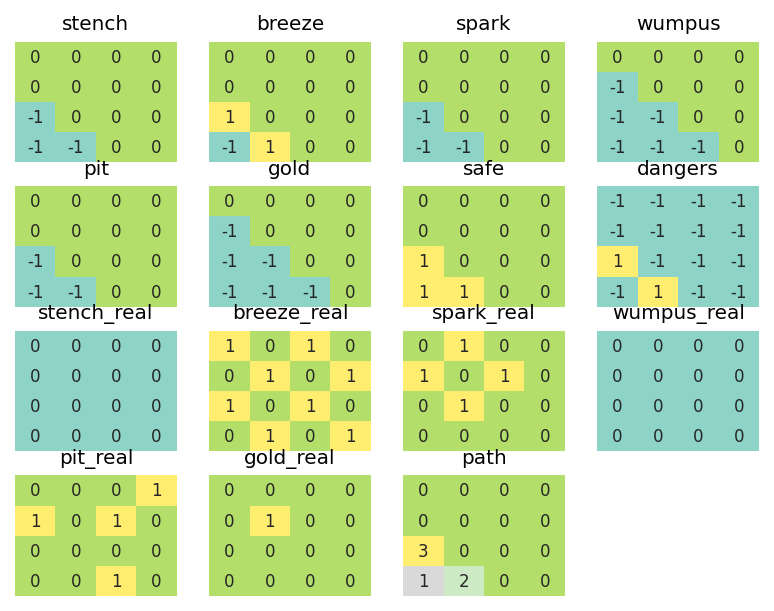

==========第4步==========
P([(0, 2)]|[])={"p":{"-1":0.6896551724,"1":0.3103448276}}
P([(1, 1)]|[])={"p":{"-1":0.1379310345,"1":0.8620689655}}
P([(2, 0)]|[])={"p":{"-1":0.6896551724,"1":0.3103448276}}
      loc  safe  wumpus       pit      score
0  (0, 2)   0.2       0  0.310345 -31.034483
1  (1, 1)   0.2       0  0.862069 -86.206897
2  (2, 0)   0.2       0  0.310345 -31.034483
这种情况不可能 [((1, 1), -1), ((2, 0), -1)]
agent移动至(0, 2),分数-104,此地有pit


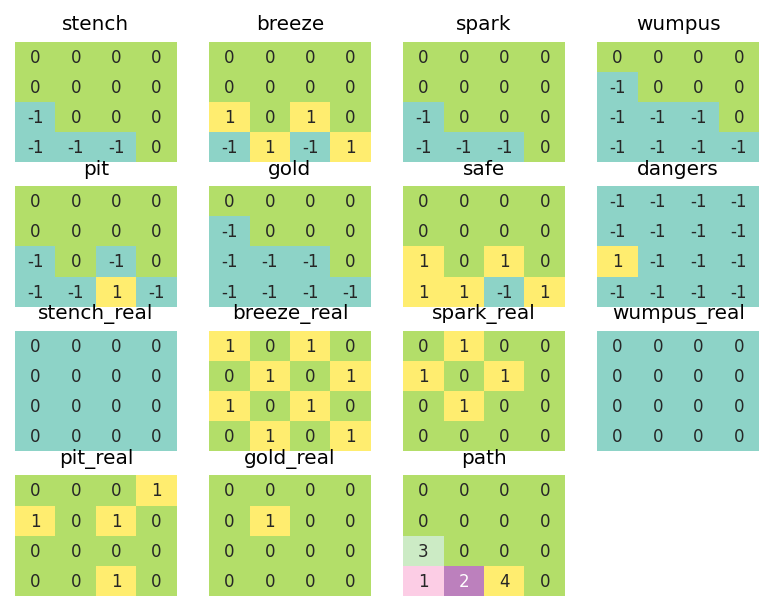

==========第5步==========
P([(1, 1)]|[])={"p":{"-1":0.4444444444,"1":0.5555555556}}
P([(2, 0)]|[])={"p":{"-1":0.4444444444,"1":0.5555555556}}
      loc  safe  wumpus       pit
0  (1, 1)   0.2       0  0.555556
1  (0, 3)   1.0       0  0.000000
2  (1, 2)   1.0       0  0.000000
3  (2, 0)   0.2       0  0.555556
这种情况不可能 [((1, 1), -1), ((2, 0), -1)]
agent移动至(0, 3),分数-105,此地有breeze


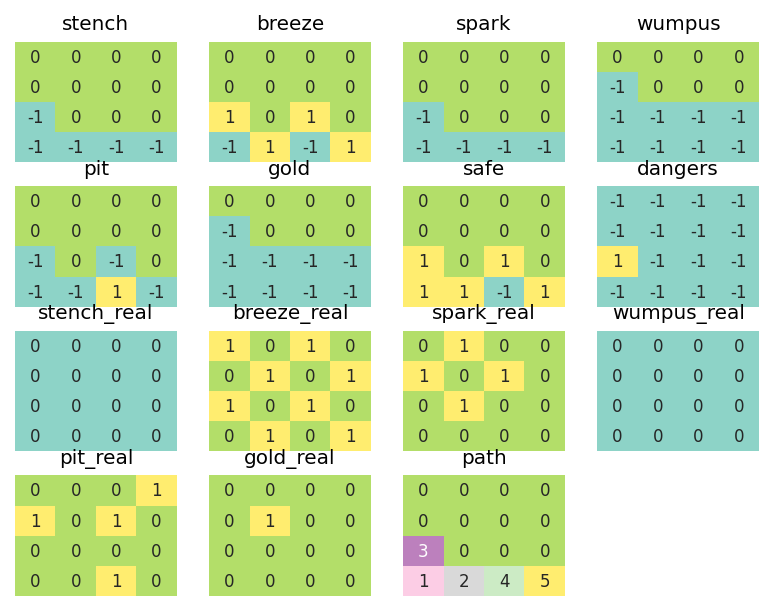

==========第6步==========
P([(1, 1)]|[])={"p":{"-1":0.4444444444,"1":0.5555555556}}
P([(1, 3)]|[])={"p":{"-1":0.8,"1":0.2}}
P([(2, 0)]|[])={"p":{"-1":0.4444444444,"1":0.5555555556}}
      loc  safe  wumpus       pit
0  (1, 1)   0.2       0  0.555556
1  (1, 2)   1.0       0  0.000000
2  (1, 3)   0.2       0  0.200000
3  (2, 0)   0.2       0  0.555556
这种情况不可能 [((1, 1), -1), ((2, 0), -1)]
agent移动至(1, 2),分数-106,此地有breeze


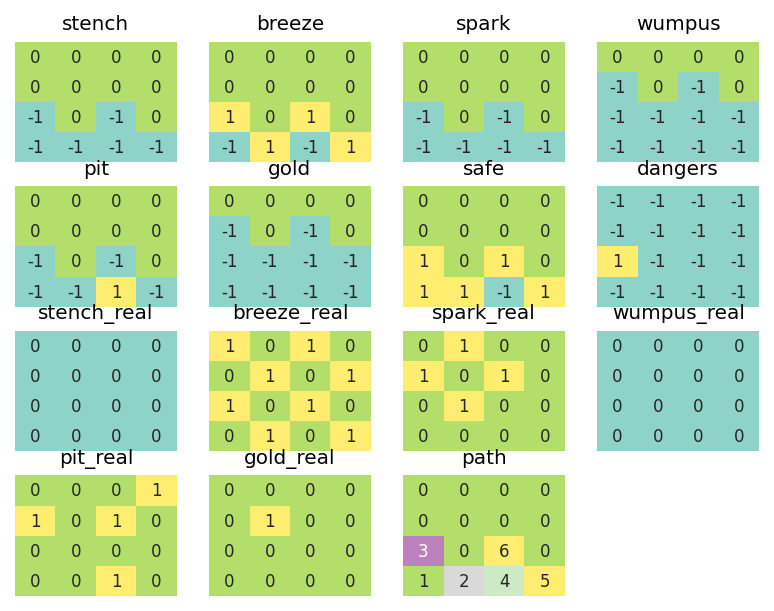

==========第7步==========
P([(1, 1)]|[])={"p":{"-1":0.4444444444,"1":0.5555555556}}
P([(1, 3)]|[])={"p":{"-1":0.8,"1":0.2}}
P([(2, 0)]|[])={"p":{"-1":0.4444444444,"1":0.5555555556}}
P([(2, 2)]|[])={"p":{"-1":0.8,"1":0.2}}
      loc  safe  wumpus       pit      score
0  (1, 1)   0.2       0  0.555556 -55.555556
1  (1, 3)   0.2       0  0.200000 -20.000000
2  (2, 0)   0.2       0  0.555556 -55.555556
3  (2, 2)   0.2       0  0.200000 -20.000000
这种情况不可能 [((1, 1), -1), ((2, 0), -1)]
agent移动至(1, 3),分数-107,此地有


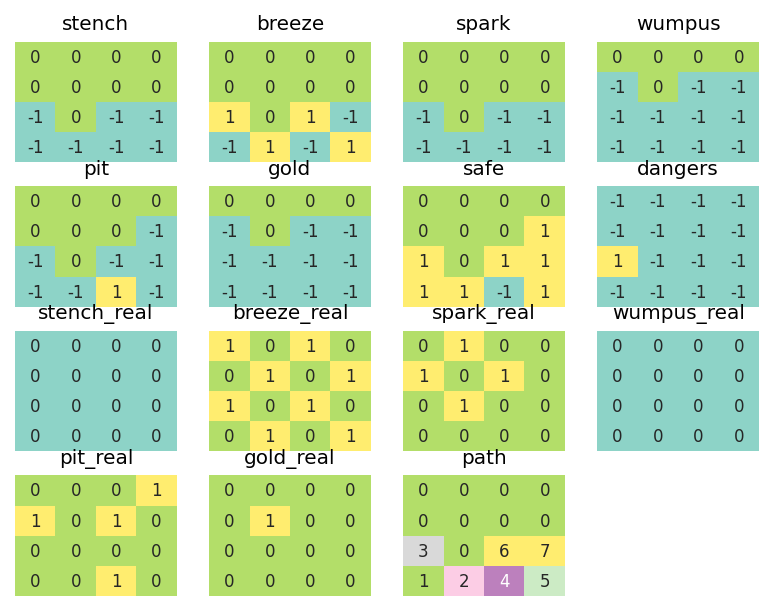

==========第8步==========
P([(1, 1)]|[])={"p":{"-1":0.4444444444,"1":0.5555555556}}
P([(2, 0)]|[])={"p":{"-1":0.4444444444,"1":0.5555555556}}
P([(2, 2)]|[])={"p":{"-1":0.8,"1":0.2}}
      loc  safe  wumpus       pit
0  (1, 1)   0.2       0  0.555556
1  (2, 0)   0.2       0  0.555556
2  (2, 2)   0.2       0  0.200000
3  (2, 3)   1.0       0  0.000000
这种情况不可能 [((2, 2), -1), ((3, 3), -1)]
这种情况不可能 [((1, 1), -1), ((2, 0), -1)]
这种情况不可能 [((2, 2), -1), ((3, 3), -1)]
agent移动至(2, 3),分数-108,此地有breeze


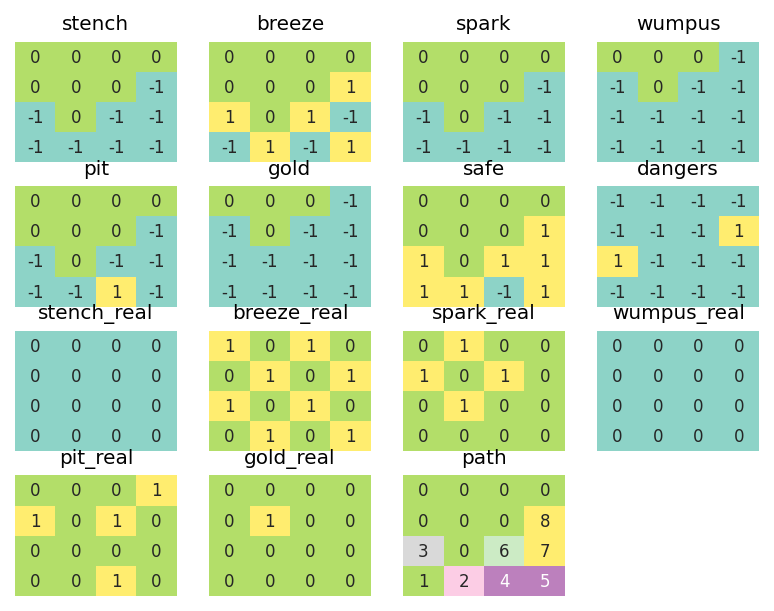

==========第9步==========
P([(1, 1)]|[])={"p":{"-1":0.4444444444,"1":0.5555555556}}
P([(2, 0)]|[])={"p":{"-1":0.4444444444,"1":0.5555555556}}
P([(2, 2)]|[])={"p":{"-1":0.4444444444,"1":0.5555555556}}
P([(3, 3)]|[])={"p":{"-1":0.4444444444,"1":0.5555555556}}
      loc  safe  wumpus       pit      score
0  (1, 1)   0.2       0  0.555556 -55.555556
1  (2, 0)   0.2       0  0.555556 -55.555556
2  (2, 2)   0.2       0  0.555556 -55.555556
3  (3, 3)   0.2       0  0.555556 -55.555556
这种情况不可能 [((2, 2), -1), ((3, 3), -1)]
这种情况不可能 [((2, 2), -1), ((3, 3), -1)]
agent移动至(1, 1),分数-109,此地有spark


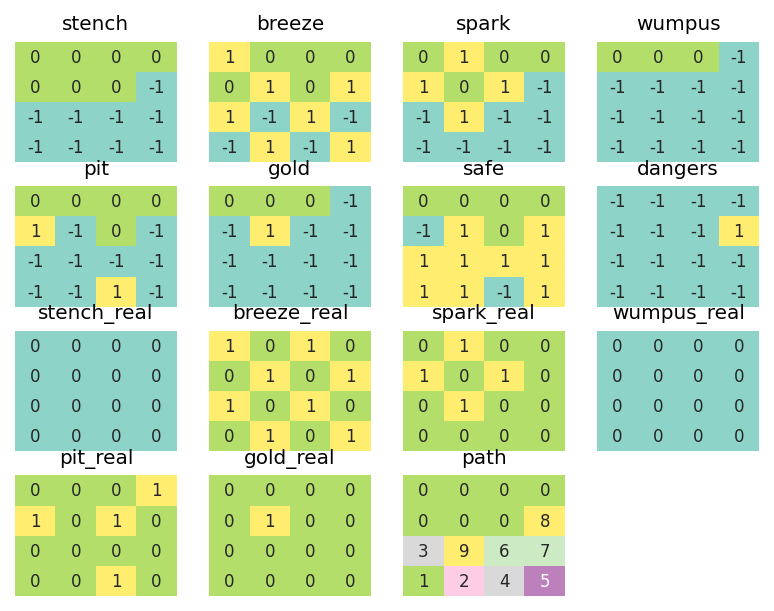

==========第10步==========
P([(2, 2)]|[])={"p":{"-1":0.4444444444,"1":0.5555555556}}
P([(3, 3)]|[])={"p":{"-1":0.4444444444,"1":0.5555555556}}
      loc  safe  wumpus       pit
0  (2, 0)   0.0       0  1.000000
1  (2, 1)   1.0       0  0.000000
2  (2, 2)   0.2       0  0.555556
3  (3, 3)   0.2       0  0.555556
这种情况不可能 [((2, 2), -1), ((3, 3), -1)]
agent移动至(2, 1),分数890,此地有breeze,gold


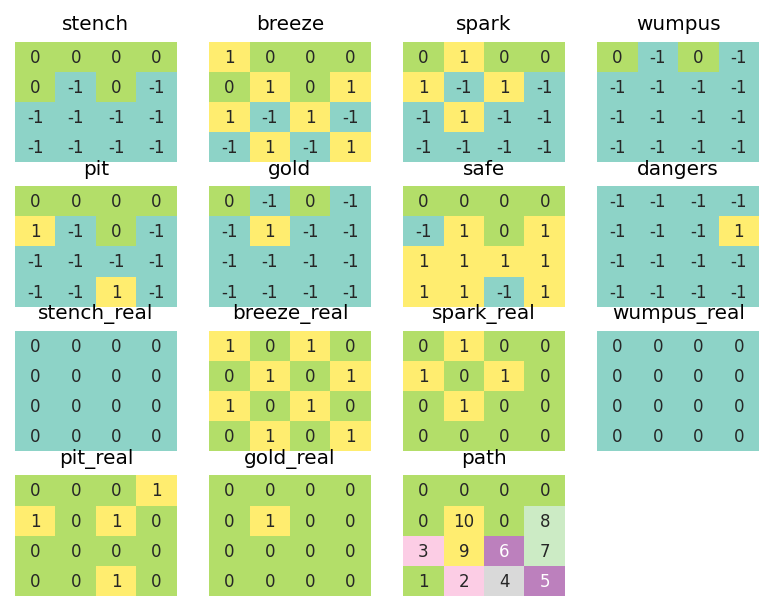

In [24]:
import random

import numpy as np
import pandas as pd
import inspect
import matplotlib.pyplot as plt
import seaborn as sns

class Rule(Thing):
    def __init__(self, kb, a, b, name='Rule'):
        self.name = name
        self.kb = kb
        # 对规则的响应方式做一下改造，a和b指名字而不是数组本身
        self.a = eval("kb.{}".format(a))
        self.b = eval("kb.{}".format(b))
        self.a_name = a
        self.b_name = b
    def update(self, loc):
        pass
    def check(self, loc):
        pass
    def node_nearby(self, lx, ly, loc):
        (x0, y0) = loc
        rs_xy = []
        for x, y in [(x0, y0 - 1), (x0, y0 + 1), (x0 - 1, y0), (x0 + 1, y0)]:
            if 0 <= x < lx and 0 <= y < ly:
                rs_xy.append((x, y))
        return rs_xy

class RuleSurrounded(Rule):
    def __init__(self, kb, a, b, name='RuleSurrounded'):
        super().__init__(kb, a, b, name)
    def update(self, loc):
        (x0, y0) = loc
        if self.a[x0][y0] == 1:
            for (x, y) in self.node_nearby(len(self.b), len(self.b[0]), (x0, y0)):
                if self.b[x][y] == 0:
                    self.kb.do_update(self.b_name, 1, (x, y))
                elif self.b[x][y] == -1:
                    print("遇到更新冲突！")
    def check(self, loc):
        (x0, y0) = loc
        if self.b[x0][y0] == -1:
            for (x, y) in self.node_nearby(len(self.b), len(self.b[0]), (x0, y0)):
                if self.a[x][y] == 1:
                    return False
        return True

class RuleIsNear(Rule):
    def __init__(self, kb, a, b, name='RuleIsNear'):
        super().__init__(kb, a, b, name)
    def update(self, loc):
        (x0, y0) = loc
        if self.a[x0][y0] == 1:
            found = False
            not_sure_nodes = []
            for (x, y) in self.node_nearby(len(self.b), len(self.b[0]), (x0, y0)):
                if self.b[x][y] == 1:
                    found = 1
                elif self.b[x][y] == 0:
                    not_sure_nodes.append((x, y))
            if not found:
                if len(not_sure_nodes) == 1:
                    (x, y) = not_sure_nodes[0]
                    self.kb.do_update(self.b_name, 1, (x, y))
                elif len(not_sure_nodes) > 1:
                    self.kb.dangers[x0][y0] = 1
                    # 关键在这里：对所有不确定点全为-1的情况排除
                    if self.b_name in self.kb.all_guess:
                        guess_key = eval("self.kb.guess_{}".format(self.b_name))
                        impossible_nodes = [(loc_imp, -1) for loc_imp in not_sure_nodes]
                        print("这种情况不可能", impossible_nodes)
                        guess_key.impossible(impossible_nodes)
                else:
                    print("逻辑冲突")
            if found and self.kb.dangers[x0][y0] == 1:
                self.kb.dangers[x0][y0] = -1

        elif self.a[x0][y0] == -1:
            for (x, y) in self.node_nearby(len(self.b), len(self.b[0]), (x0, y0)):
                if self.b[x][y] == 0:
                    self.kb.do_update(self.b_name, -1, (x, y))
                elif self.b[x][y] == 1:
                    print("遇到更新冲突！")
    def check(self, loc):
        (x0, y0) = loc
        if self.b[x0][y0] == -1:
            for (x, y) in self.node_nearby(len(self.b), len(self.b[0]), (x0, y0)):
                if self.a[x][y] == 1:
                    return False
        return True

class RuleIs(Rule):
    def __init__(self, kb, a, b, name='RuleIs'):
        super().__init__(kb, a, b, name)
    def update(self, loc):
        (x0, y0) = loc
        if self.a[x0][y0] == 1:
            if self.b[x0][y0] == 0:
                self.kb.do_update(self.b_name, 1, (x0, y0))
            elif self.b[x0][y0] == -1:
                print("遇到更新冲突！")
    def check(self, loc):
        (x0, y0) = loc
        return self.b[x0][y0] == -1 and self.a[x0][y0] == -1

class RuleIsNot(Rule):
    def __init__(self, kb, a, b, name='RuleIsNot'):
        super().__init__(kb, a, b, name)
    def update(self, loc):
        (x0, y0) = loc
        if self.a[x0][y0] == 1:
            if self.b[x0][y0] == 0:
                self.kb.do_update(self.b_name, -1, (x0, y0))
            elif self.b[x0][y0] == 1:
                print("遇到更新冲突！")
    def check(self, loc):
        (x0, y0) = loc
        return self.b[x0][y0] == 1 and self.a[x0][y0] == -1

class RuleAreOrNot(Rule):
    def __init__(self, kb, a, b, name='RuleAreOrNot'):
        super().__init__(kb, 'safe', b, name)  # 随便给一个给父类，再覆盖
        a_toks = [tok.strip() for tok in a.split("|")]
        self.a = []
        for a_tok in a_toks:
            self.a.append(eval("kb." + a_tok))
        self.a_name = a
    def update(self, loc):
        (x0, y0) = loc
        if self.b[x0][y0] != 1:
            a_negtive_count = 0
            for a_map in self.a:
                if a_map[x0][y0] == 1:
                    if self.b[x0][y0] == 0:
                        self.kb.do_update(self.b_name, -1, (x0, y0))
                    elif self.b[x0][y0] == 1:
                        print("遇到更新冲突！")
                elif a_map[x0][y0] == -1:
                    a_negtive_count += 1
            if a_negtive_count == len(self.a):
                self.kb.do_update(self.b_name, 1, (x0, y0))
    def check(self, loc):
        (x0, y0) = loc
        if self.b[x0][y0] == 1:
            for a_map in self.a:
                if a_map[x0][y0] != 1:
                    return False
        return True

class KB(Thing):
    def __init__(self, name=''):
        self.name = name
    def learn(self, expr):
        pass
    def ask(self, loc, expr):
        pass

class WumpusKB(KB):
    def __init__(self, name='WumpusKB', n=4):
        super().__init__(name)
        not_sure_arr = np.zeros((n, n), dtype=int)
        self.stench = not_sure_arr.copy()
        self.breeze = not_sure_arr.copy()
        self.spark = not_sure_arr.copy()
        self.wumpus = not_sure_arr.copy()
        self.pit = not_sure_arr.copy()
        self.gold = not_sure_arr.copy()
        self.safe = not_sure_arr.copy()
        self.dangers = not_sure_arr.copy() - 1
        self.all_states = ['stench', 'breeze', 'spark', 'wumpus', 'pit', 'gold', 'safe', 'dangers']
        self.all_recepts = ['stench', 'breeze', 'spark', 'wumpus', 'pit', 'gold']
        self.rules = []
        self.dolist = [dof[0][3:] for dof in inspect.getmembers(self, predicate=inspect.ismethod) if
                       dof[0].startswith("do_")]
        self.update_queue = []
        # 下面在kb中添加guess
        self.all_guess = ['pit', 'wumpus', 'gold']
        self.guess_pit = WumpusGuess()
        self.guess_wumpus = WumpusGuess()
        self.guess_gold = WumpusGuess()
    def learn(self, expr):
        expr = expr.strip()
        toks = expr.split(" ")
        if len(toks) == 3 and toks[1] in self.dolist:
            eval_str = "self.do_{}('{}','{}','{}')".format(toks[1], toks[0], toks[2], expr)
            eval(eval_str)
        else:
            print("请检查输入的指令")
    # 改造ask，不再返回-1/0/1，而是为1的概率
    def ask(self, loc, expr):
        (x0, y0) = loc
        map_key = eval("self.{}".format(expr))
        if map_key[x0][y0] != 0:
            return 1.0 if map_key[x0][y0] > 0 else 0
        else:
            map_key[x0][y0] = 1
            check_1 = True
            for rule in self.rules:
                if not rule.check((x0, y0)):
                    check_1 = False
                    break
            map_key[x0][y0] = -1
            check_2 = True
            for rule in self.rules:
                if not rule.check((x0, y0)):
                    check_2 = False
                    break
            if check_1 and not check_2:
                map_key[x0][y0] = 1
                self.add_update_if_not_exists((x0, y0))
                return 1.0
            elif not check_1 and check_2:
                map_key[x0][y0] = -1
                self.add_update_if_not_exists((x0, y0))
                return 0
            else:
                map_key[x0][y0] = 0
                if expr in self.all_guess:
                    guess_key = eval("self.guess_{}".format(expr))
                    guess_result = guess_key.cal_p_cond([loc])['p']
                    if 1 in guess_result:
                        return guess_result[1]
                    else:
                        return 0
                else:
                    return 0.2  # 如果无法判断，以0.2代替
    def add_update_if_not_exists(self, loc):
        if loc not in self.update_queue and self.dangers[loc[0], loc[1]] != 1:
            self.update_queue.append(loc)
    def update_all_node(self):
        while len(self.update_queue) > 0:
            loc = self.update_queue.pop()
            for rule in self.rules:
                rule.update(loc)
        for loc in zip(np.where(self.dangers == 1)[0], np.where(self.dangers == 1)[1]):
            for rule in self.rules:
                rule.update(loc)
        if len(self.update_queue) > 0:
            self.update_all_node()
    def visit(self, loc, views=[]):
        (x0, y0) = loc
        for view in views:
            self.do_update(view, 1, (x0, y0))
        for recept in self.all_recepts:
            if recept not in views:
                self.do_update(recept, -1, (x0, y0))
        self.update_all_node()
    def do_is(self, a, b, expr):
        rule = RuleIs(self, a, b, expr)
        self.rules.append(rule)
    def do_is_not(self, a, b, expr):
        rule = RuleIsNot(self, a, b, expr)
        self.rules.append(rule)
    def do_is_surrounded_by(self, a, b, expr):
        rule = RuleSurrounded(self, a, b, expr)
        self.rules.append(rule)
    def do_is_near(self, a, b, expr):
        rule = RuleIsNear(self, a, b, expr)
        self.rules.append(rule)
    def do_are_or_not(self, a, b, expr):
        rule = RuleAreOrNot(self, a, b, expr)
        self.rules.append(rule)
    def show(self):
        plt.rcdefaults()
        plt.rcParams['figure.dpi'] = 150
        plt.rcParams['font.size'] = 8
        for idx, name in zip(range(1, 100), self.all_states):
            plt.subplot(4, 4, idx)
            map_key = eval("self.{}".format(name))
            ax = sns.heatmap(map_key,
                             cmap='Set3',
                             center=0,
                             annot=True,
                             cbar=False,
                             xticklabels=0,
                             yticklabels=0, )
            ax.invert_yaxis()
            plt.title(name)
        plt.show()
    # 需要做拦截，将所有更新逻辑写入此函数中
    def do_update(self, key, val, loc):
        (x0, y0) = loc
        map_key = eval("self.{}".format(key))
        map_key[x0][y0] = val
        self.add_update_if_not_exists(loc)
        # 更新完后，更新联合分布
        if key in self.all_guess:
            guess_key = eval("self.guess_{}".format(key))
            guess_key.watch([(loc, val)])

class Agent(Thing):
    def __init__(self, world, name='agent', loc=None):
        super().__init__(name)
        self.world = world
        self.loc = loc
        self.score = 0
        self.order = 0
        self.all_actions = [
            dof[0][3:]
            for dof in inspect.getmembers(self, predicate=inspect.ismethod)
            if dof[0].startswith("do_")]
    def do_move_to(self, loc):
        (x0, y0) = loc
        if self.world.move_available((x0, y0)):
            self.move_to((x0, y0))
        else:
            print("无法移动到{}".format((x0, y0)))
    def do_move_direction(self, direction):
        (x0, y0), (xd, yd) = self.loc, direction
        if self.world.move_available((x0 + xd), (y0 + yd)):
            self.move_to((x0 + xd), (y0 + yd))
        else:
            print("无法移动到{}".format((x0, y0)))
    def move_to(self, loc):
        (x0, y0) = loc
        self.loc = (x0, y0)
        self.order += 1
        self.score -= 1
        self.world.path[x0][y0] = self.order
        loc_states = self.world.loc_states(loc)
        self.score += 1000 if 'gold' in loc_states else 0
        self.score -= 1000 if 'wumpus' in loc_states else 0
        self.score -= 100 if 'pit' in loc_states else 0
        print("{},此地有{}".format(self, ",".join(loc_states)))
    def __repr__(self):
        return "agent移动至{},分数{}".format(self.loc, self.score)

class Problem(Thing):
    def __init__(self, name):
        super().__init__(name)

class GameProblem(Problem):
    def __init__(self, name):
        super().__init__(name)
    def check_win(self):
        pass

class GuessWumpusWorld(GameProblem):
    def __init__(self, name='LogicWumpusWorld', n=4):
        super().__init__(name)
        self.n = n
        # 知识库
        kb = WumpusKB(n)
        for line in open("../data/wumpus.rules","r"):
            kb.learn(line)
        self.kb = kb
        zero_arr = np.zeros((n, n), dtype=int)
        self.path = zero_arr.copy()
        self.stench_real = zero_arr.copy()
        self.breeze_real = zero_arr.copy()
        self.spark_real = zero_arr.copy()
        self.wumpus_real = zero_arr.copy()
        self.pit_real = zero_arr.copy()
        self.gold_real = zero_arr.copy()
        self.real_states = ['stench_real',
                            'breeze_real',
                            'spark_real',
                            'wumpus_real',
                            'pit_real',
                            'gold_real', ]
        for state in self.real_states:
            exec("kb.{} = self.{}".format(state, state))
            kb.all_states.append(state)
        kb.path = self.path
        kb.all_states.append('path')
        self.agent = Agent(self)
        code_trans = {2: ('wumpus_real', 'stench_real'),
                      3: ('pit_real', 'breeze_real'),
                      4: ('gold_real', 'spark_real'), }
        map_src = pd.read_csv("../data/wumpus_world_2.csv", header=None)
        for row_id, col in map_src.iterrows():
            for col_id, val in col.items():
                if val == 1:
                    self.agent.do_move_to((row_id, col_id))
                if val in code_trans:
                    exec("self.{}[{}][{}]=1".format(code_trans[val][0], row_id, col_id))
                    for pos in self.node_nearby(self.n, self.n, (row_id, col_id)):
                        exec("self.{}[{}][{}]=1".format(code_trans[val][1], pos[0], pos[1]))
        self.show()
    def show(self):
        self.kb.show()
    def node_nearby(self, lx, ly, loc):
        (x0, y0) = loc
        rs_xy = []
        for x, y in [(x0, y0 - 1), (x0, y0 + 1), (x0 - 1, y0), (x0 + 1, y0)]:
            if 0 <= x < lx and 0 <= y < ly:
                rs_xy.append((x, y))
        return rs_xy
    def move_available(self, loc):
        (x0, y0) = loc
        if 0 <= x0 < self.n and 0 <= y0 < self.n:
            if self.path[x0][y0] == 0:
                return True
        return False
    def loc_states(self, loc):
        (x0, y0) = loc
        real_states = []
        for state in self.real_states:
            if eval("self.{}[{}][{}]==1".format(state, x0, y0)):
                state = state[:-5] if state.endswith("_real") else state
                real_states.append(state)
        self.kb.visit(loc, real_states)
        return real_states
    def move_to(self, loc):
        self.agent.do_move_to(loc)
        self.show()
    def act(self):
        visited_locs = np.concatenate([(np.where(self.path > 0))], axis=0).T
        nearby_unvisited_locs = []
        for (x, y) in visited_locs:
            for (x1, y1) in self.node_nearby(self.n, self.n, (x, y)):
                if self.path[x1][y1] == 0 and (x1, y1) not in nearby_unvisited_locs:
                    nearby_unvisited_locs.append((x1, y1))
        unvisited_locs = []
        for loc in nearby_unvisited_locs:
            unvisited_locs.append([loc,
                                   self.kb.ask(loc, 'safe'),
                                   self.kb.ask(loc, 'wumpus'),
                                   self.kb.ask(loc, 'pit')])
        unvisited_p = pd.DataFrame(unvisited_locs,
                                   columns=['loc',
                                            'safe',
                                            'wumpus',
                                            'pit'])
        choose_loc = None
        if unvisited_p['safe'].max() > 0.99:
            choose_loc = unvisited_p['loc'][unvisited_p['safe'].argmax()]
        else:
            unvisited_p['score'] = unvisited_p['wumpus'] * (-1000) + unvisited_p['pit'] * (-100)
            choose_loc = unvisited_p['loc'][unvisited_p['score'].argmax()]
        print(unvisited_p)
        if choose_loc is not None:
            self.move_to(choose_loc)
        else:
            print("agent没有可以执行的操作")

print("==========第1步==========")
world = GuessWumpusWorld()
for epoch in range(2, 11):
    print("==========第{}步==========".format(epoch))
    world.act()